# Residual State Engine - Backtest Analysis

This notebook analyzes structural health metrics and lifecycle behavior for the
ResidualStateEngine algorithm. It focuses on internal metrics and avoids
PnL-driven conclusions.

In [331]:
from pathlib import Path
import json
import re

import numpy as np
import matplotlib.pyplot as plt

try:
    import pandas as pd
except ImportError as exc:
    raise ImportError(
        "pandas is required to run this notebook. Install with: pip install pandas"
    ) from exc

pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = (12, 4)


In [332]:
# If BACKTEST_DIR is None, the latest backtest is auto-selected.
# Set BACKTEST_DIR to a specific folder to override.
BACKTEST_DIR = None  # example: Path("/absolute/path/to/backtests/2025-12-22_19-56-34")

BACKTEST_ROOTS = [
    Path.home() / "lean-cli-root" / "ResidualStateEngine" / "backtests",
]


def _candidate_dirs(roots):
    candidates = []
    for root in roots:
        if not root.exists():
            continue
        for child in root.iterdir():
            if child.is_dir():
                candidates.append(child)
    return candidates


def _find_json(backtest_dir):
    json_files = []
    for path in backtest_dir.glob("*.json"):
        # skip summary/config-like files and order events
        if path.name.endswith("-summary.json") or path.name.endswith("-order-events.json"):
            continue
        json_files.append(path)
    return json_files


def _has_health_chart(json_path):
    try:
        data = json.loads(json_path.read_text())
    except Exception:
        return False
    if not isinstance(data, dict):
        return False
    charts = data.get("charts", {})
    return "Health" in charts


def _log_has_state(log_path):
    try:
        with log_path.open() as f:
            for line in f:
                if "state=" in line:
                    return True
    except Exception:
        return False
    return False


def select_backtest():
    if BACKTEST_DIR:
        return Path(BACKTEST_DIR)

    candidates = _candidate_dirs(BACKTEST_ROOTS)
    scored = []
    for cand in candidates:
        json_files = _find_json(cand)
        if not json_files:
            continue
        has_health = any(_has_health_chart(p) for p in json_files)
        # score by presence of Health, then by mtime
        scored.append((has_health, cand.stat().st_mtime, cand))

    if not scored:
        raise FileNotFoundError("No backtest folders found in BACKTEST_ROOTS")

    scored.sort(key=lambda x: (x[0], x[1]))
    return scored[-1][2]


def select_json(backtest_dir):
    json_files = _find_json(backtest_dir)
    if not json_files:
        raise FileNotFoundError(f"No JSON results in {backtest_dir}")
    # Prefer the JSON with Health chart.
    health = [p for p in json_files if _has_health_chart(p)]
    return health[0] if health else json_files[0]


def select_log(backtest_dir):
    candidates = list(backtest_dir.glob("*log.txt"))
    if not candidates:
        raise FileNotFoundError(f"No log files in {backtest_dir}")

    # Prefer logs that contain state= lines.
    state_logs = [p for p in candidates if _log_has_state(p)]
    if state_logs:
        return max(state_logs, key=lambda p: p.stat().st_size)

    # Fallback: largest log.txt
    return max(candidates, key=lambda p: p.stat().st_size)


backtest_dir = select_backtest()
backtest_json = select_json(backtest_dir)
backtest_log = select_log(backtest_dir)

print("Backtest dir:", backtest_dir)
print("JSON:", backtest_json.name)
print("Log:", backtest_log.name)

Backtest dir: /Users/javiergonzalez-quijanoalvarez/lean-cli-root/ResidualStateEngine/backtests/2025-12-23_02-28-38
JSON: 1725405904.json
Log: log.txt


In [333]:
with backtest_json.open() as f:
    bt_data = json.load(f)

algo_config = bt_data.get("algorithmConfiguration", {})
algo_params = algo_config.get("parameters", {}) or {}
stats = bt_data.get("statistics", {})
runtime_stats = bt_data.get("runtimeStatistics", {})

print("Algorithm name:", algo_config.get("name"))
print("Parameters:", algo_params)
print("Statistics keys:", list(stats.keys())[:8])

Algorithm name: None
Parameters: {}
Statistics keys: []


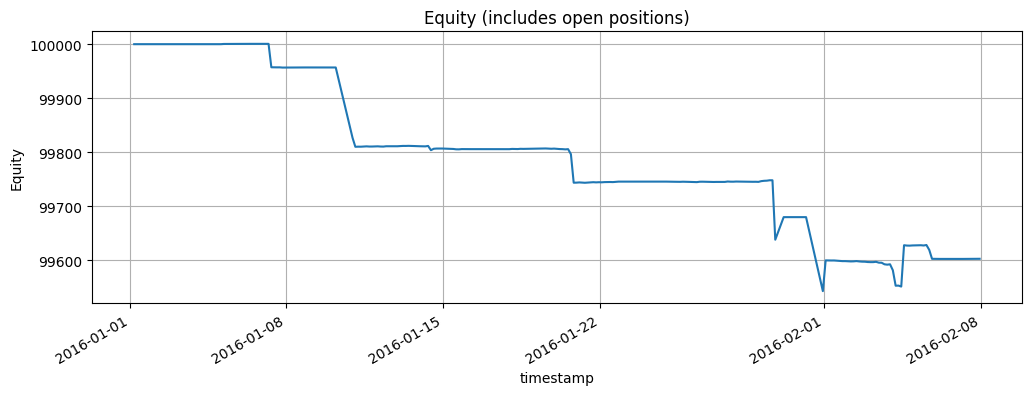

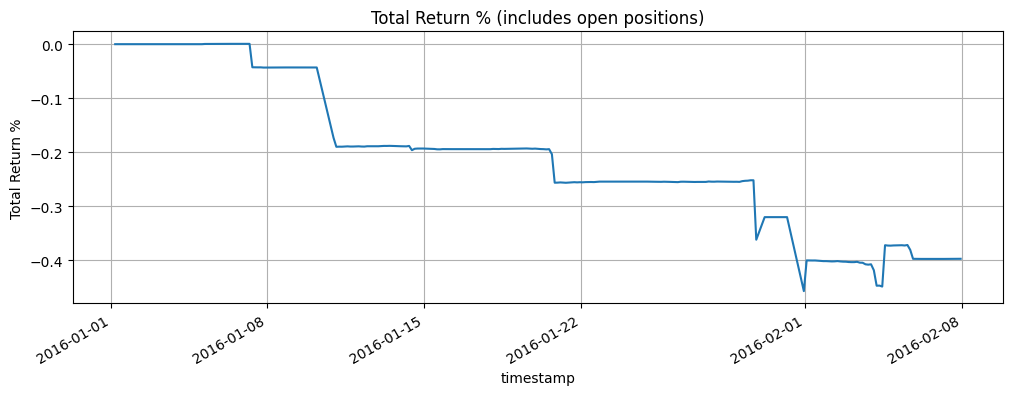

In [334]:
# Total return time series (includes open positions)
equity_df = None
charts = bt_data.get("charts", {})
equity_chart = charts.get("Strategy Equity") or charts.get("Equity")
if equity_chart:
    series = equity_chart.get("series", {}).get("Equity")
    if series and "values" in series:
        values = series["values"]
        rows = []
        for v in values:
            try:
                ts = v[0]
                close = v[-1]
            except Exception:
                continue
            rows.append((ts, close))
        if rows:
            equity_df = pd.DataFrame(rows, columns=["timestamp", "equity"])
            equity_df["timestamp"] = pd.to_datetime(equity_df["timestamp"], unit="s", utc=True)
            equity_df["timestamp"] = equity_df["timestamp"].dt.tz_convert(None)
            equity_df = equity_df.set_index("timestamp")
            base = float(equity_df["equity"].iloc[0])
            equity_df["total_return_pct"] = (equity_df["equity"] / base - 1.0) * 100.0

if equity_df is None:
    print("No Strategy Equity chart data found.")
else:
    ax = equity_df["equity"].plot(title="Equity (includes open positions)")
    ax.set_ylabel("Equity")
    plt.grid(True)
    plt.show()
    ax = equity_df["total_return_pct"].plot(title="Total Return % (includes open positions)")
    ax.set_ylabel("Total Return %")
    plt.grid(True)
    plt.show()


In [335]:
# Extract Health chart series (if present)
charts = bt_data.get("charts", {})
health_chart = charts.get("Health")

health_df = None
if health_chart:
    series = health_chart.get("series", {})

    def series_to_df(name, payload):
        values = payload.get("values", [])
        df = pd.DataFrame(values, columns=["timestamp", name])
        df["time"] = pd.to_datetime(df["timestamp"], unit="s", utc=True)
        return df[["time", name]]

    frames = []
    for name, payload in series.items():
        frames.append(series_to_df(name, payload))

    if frames:
        health_df = frames[0]
        for frame in frames[1:]:
            health_df = health_df.merge(frame, on="time", how="outer")

        health_df = health_df.sort_values("time")
        health_df = health_df.set_index("time")

health_df.head() if health_df is not None else "Health chart not found"

,neutrality_err,subspace_angle,energy,turnover,w_norm,alignment,factor_leakage,signal_strength
time,,,,,,,,
2015-08-24 13:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-24 14:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-24 15:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-24 16:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-24 17:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
# Parse Debug lines into a structured table
metric_pattern = re.compile(
    r"\| N=(?P<N>\d+) K=(?P<K>\d+) T=(?P<T>\d+) \| "
    r"signal=(?P<signal>[-\d\.]+) persist=(?P<persist>\d+) \| "
    r"w_norm=(?P<w_norm>[-\d\.]+) energy=(?P<energy>[-\d\.]+) turnover=(?P<turnover>[-\d\.]+) \| "
    r"neutrality_err=(?P<neutrality_err>[-\d\.]+) \| state=(?P<state>[\w_]+)"
    r"(?: \| angle=(?P<angle>[-\d\.]+))?"
    r"(?: \| leakage=(?P<leakage>[-\d\.]+))?"
)

summary_pattern = re.compile(
    r"SUMMARY \| rebalances=(?P<rebalances>\d+) trades=(?P<trades>\d+) shutdowns=(?P<shutdowns>\d+) \| "
    r"avg_w_norm=(?P<avg_w_norm>[-\d\.]+) max_w_norm=(?P<max_w_norm>[-\d\.]+) \| "
    r"avg_energy=(?P<avg_energy>[-\d\.]+) max_energy=(?P<max_energy>[-\d\.]+) \| "
    r"avg_turnover=(?P<avg_turnover>[-\d\.]+) max_turnover=(?P<max_turnover>[-\d\.]+) \| "
    r"avg_neutrality=(?P<avg_neutrality>[-\d\.]+) max_neutrality=(?P<max_neutrality>[-\d\.]+)"
)

summary = None
terminated = None
records = []
raw_state_lines = []

with backtest_log.open() as f:
    for line in f:
        if "SUMMARY |" in line:
            m = summary_pattern.search(line)
            if m:
                summary = {k: float(v) if "." in v else int(v) for k, v in m.groupdict().items()}
            continue
        if "SYSTEM TERMINATED" in line or "SYSTEM COMPLETED" in line:
            terminated = line.strip()
            continue
        if "state=" not in line:
            continue
        raw_state_lines.append(line)
        m = metric_pattern.search(line)
        if not m:
            continue
        dates = re.findall(r"\d{4}-\d{2}-\d{2}", line)
        date_str = dates[-1] if dates else None
        record = m.groupdict()
        record["date"] = date_str
        records.append(record)

log_df = pd.DataFrame(records)
for col in ["N", "K", "T", "persist"]:
    if col in log_df:
        log_df[col] = pd.to_numeric(log_df[col], errors="coerce")
for col in ["signal", "w_norm", "energy", "turnover", "neutrality_err", "angle", "leakage"]:
    if col in log_df:
        log_df[col] = pd.to_numeric(log_df[col], errors="coerce")

if "date" in log_df:
    log_df["date"] = pd.to_datetime(log_df["date"], errors="coerce")

if log_df.empty:
    print("No metric rows parsed from log.")
    print("Log path:", backtest_log)
    print("Lines containing state=:", len(raw_state_lines))
    if raw_state_lines:
        print("Example line:", raw_state_lines[0].rstrip())
    else:
        print("Hint: set BACKTEST_DIR to a backtest folder with Debug state logs.")

log_df.head()


,N,K,T,signal,persist,w_norm,energy,turnover,neutrality_err,state,angle,leakage,date
0,9,3,0,0.0,0,0.0,0.0,0.0,0.0,no_signal,0.0,0.0,2015-08-24
1,9,3,0,0.0,0,0.0,0.0,0.0,0.0,no_signal,0.0,0.0,2015-08-25
2,9,3,0,0.0,0,0.0,0.0,0.0,0.0,no_signal,0.0,0.0,2015-08-26
3,9,3,0,0.0,0,0.0,0.0,0.0,0.0,no_signal,0.0,0.0,2015-08-27
4,9,3,0,0.0,0,0.0,0.0,0.0,0.0,no_signal,0.0,0.0,2015-08-28


## Summary (from algorithm logs)

In [337]:
print("Summary:", summary)
print("Termination:", terminated)
print("Rows parsed:", len(log_df))
print("States:")
if "state" in log_df.columns:
    print(log_df["state"].value_counts())
else:
    print("No state column parsed from logs.")

Summary: None
Termination: None
Rows parsed: 922
States:
state
no_signal       764
rebalance_ok    110
no_coherence     48
Name: count, dtype: int64


In [338]:
# Basic activity diagnostics
if "w_norm" in log_df.columns:
    log_df["active"] = log_df["w_norm"] > 0
else:
    log_df["active"] = False

if "state" in log_df.columns:
    log_df["shutdown"] = log_df["state"].str.startswith("shutdown")
    log_df["cooldown"] = log_df["state"] == "shutdown_cooldown"
else:
    log_df["shutdown"] = False
    log_df["cooldown"] = False

active_ratio = log_df["active"].mean() if len(log_df) else 0.0
shutdown_ratio = log_df["shutdown"].mean() if len(log_df) else 0.0

print(f"Active ratio: {active_ratio:.3f}")
print(f"Shutdown ratio: {shutdown_ratio:.3f}")

Active ratio: 0.119
Shutdown ratio: 0.000


## Time Series (Health Metrics)

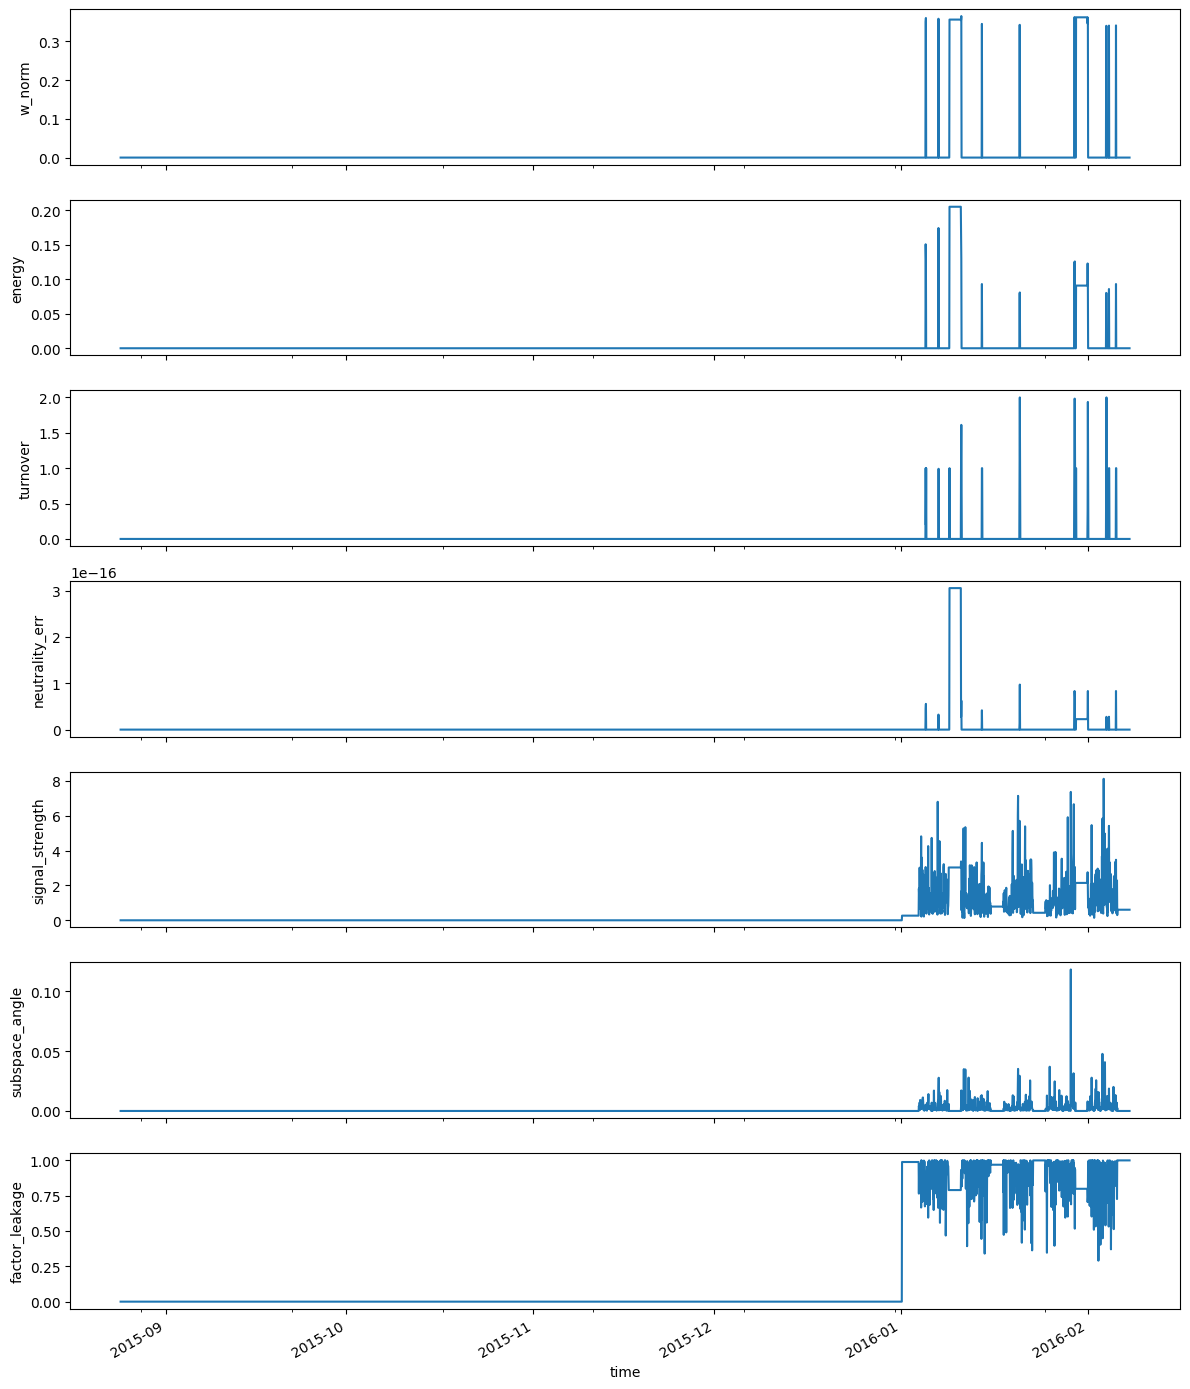

In [339]:
if health_df is not None:
    metrics = ["w_norm", "energy", "turnover", "neutrality_err", "signal_strength", "subspace_angle", "factor_leakage"]
    metrics = [m for m in metrics if m in health_df]
    if not metrics:
        print("No Health metrics available.")
    else:
        fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 2 * len(metrics)), sharex=True)
        if len(metrics) == 1:
            axes = [axes]
        for ax, metric in zip(axes, metrics):
            health_df[metric].plot(ax=ax)
            ax.set_ylabel(metric)
        plt.tight_layout()
else:
    print("Health chart not found in JSON.")


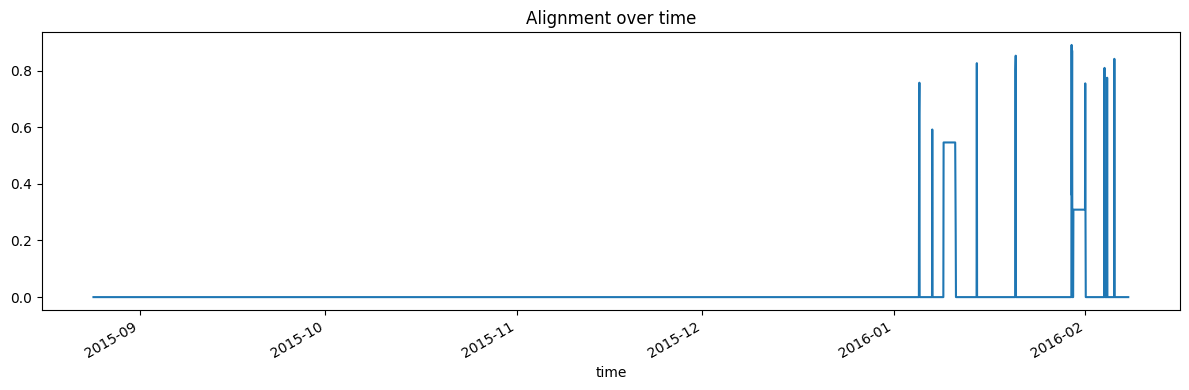

In [340]:
if health_df is not None and "alignment" in health_df:
    health_df["alignment"].plot(title="Alignment over time")
    plt.tight_layout()

## Distributions and Relationships

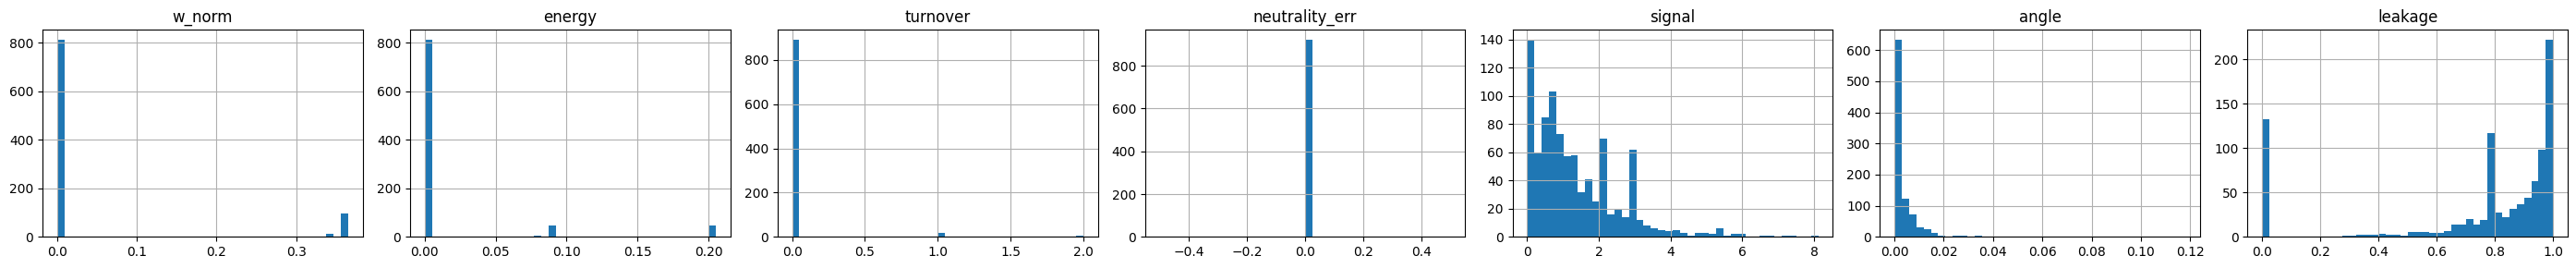

In [341]:
metrics = ["w_norm", "energy", "turnover", "neutrality_err", "signal", "angle", "leakage"]
metrics = [m for m in metrics if m in log_df]
if not metrics:
    print("No metrics available for distributions.")
else:
    fig, axes = plt.subplots(1, len(metrics), figsize=(max(4 * len(metrics), 8), 3))
    if len(metrics) == 1:
        axes = [axes]
    for ax, metric in zip(axes, metrics):
        log_df[metric].hist(ax=ax, bins=40)
        ax.set_title(metric)
    plt.tight_layout()


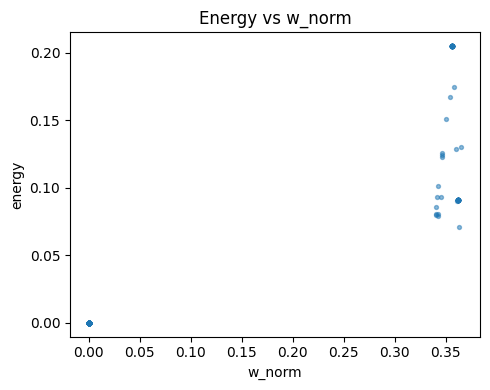

In [342]:
# Energy vs w_norm
if {"energy", "w_norm"}.issubset(log_df.columns):
    plt.figure(figsize=(5, 4))
    plt.scatter(log_df["w_norm"], log_df["energy"], s=8, alpha=0.5)
    plt.xlabel("w_norm")
    plt.ylabel("energy")
    plt.title("Energy vs w_norm")
    plt.tight_layout()

## State and Shutdown Analysis

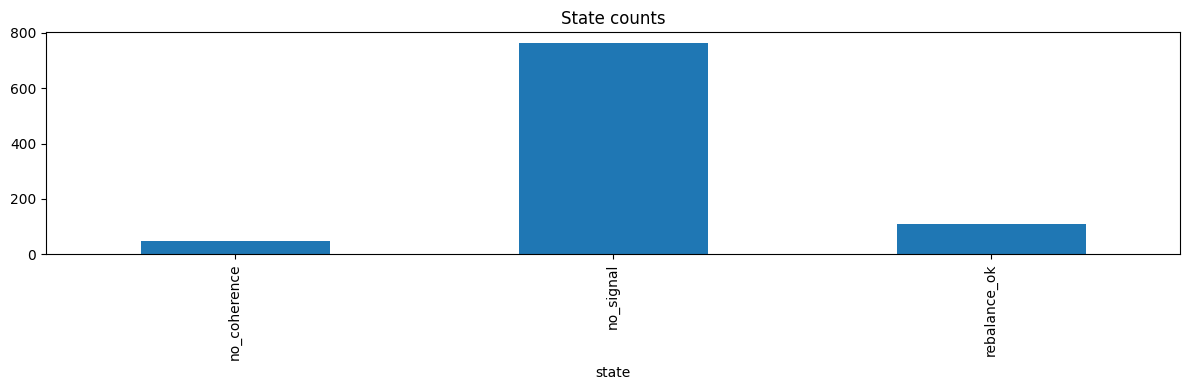

In [343]:
if "state" in log_df.columns:
    state_counts = log_df["state"].value_counts().sort_index()
    state_counts.plot(kind="bar", title="State counts")
    plt.tight_layout()
else:
    print("No state column parsed from logs.")

In [344]:
# Cooldown duration analysis
cooldown_df = log_df[log_df["cooldown"]].copy()
if not cooldown_df.empty:
    cooldown_blocks = (log_df["cooldown"] != log_df["cooldown"].shift()).cumsum()
    cooldown_lengths = log_df[log_df["cooldown"]].groupby(cooldown_blocks).size()
    print("Cooldown count:", len(cooldown_lengths))
    print("Cooldown durations (rebalance steps):")
    print(cooldown_lengths.describe())
else:
    print("No cooldown periods detected.")

No cooldown periods detected.


## Regime Segmentation

In [345]:
# Use health_df timestamps for regime segmentation if available
if health_df is not None:
    df = health_df.copy()
    df.index = df.index.tz_convert(None)
elif "date" in log_df.columns:
    df = log_df.dropna(subset=["date"]).copy()
    df = df.set_index("date")
else:
    df = None

regimes = {
    "pre_2020": ("2013-01-01", "2019-12-31"),
    "2020_2021": ("2020-01-01", "2021-12-31"),
    "2022_2024": ("2022-01-01", "2024-12-31"),
}

if df is None or df.empty:
    print("No time index available for regime segmentation.")
else:
    rows = []
    for name, (start, end) in regimes.items():
        seg = df.loc[start:end]
        if seg.empty:
            continue
        row = {
            "regime": name,
            "count": len(seg),
        }
        for col in ["w_norm", "energy", "turnover", "neutrality_err", "signal_strength"]:
            if col in seg:
                row[f"avg_{col}"] = float(seg[col].mean())
                row[f"max_{col}"] = float(seg[col].max())
        rows.append(row)

    regime_df = pd.DataFrame(rows)
    display(regime_df)

,regime,count,avg_w_norm,max_w_norm,avg_energy,max_energy,avg_turnover,max_turnover,avg_neutrality_err,max_neutrality_err,avg_signal_strength,max_signal_strength
0,pre_2020,4018,0.009701,0.365235,0.003857,0.205211,0.008242,2.0,3.959288e-18,3.053113e-16,0.305611,8.116561


## Structural Pass/Fail Checks (Configurable)

In [346]:
# Defaults aligned with algorithm defaults or backtest parameters.
algo_params = globals().get("algo_params", {}) or {}

def _param_float(name, default):
    try:
        return float(algo_params.get(name, default))
    except Exception:
        return default

NEUTRALITY_FAIL_TOL = _param_float("neutrality_fail_tol", 1e-3)
MAX_ENERGY = _param_float("max_energy", 10.0)
SIGNAL_THRESHOLD = _param_float("signal_threshold", 2.0)
SUBSPACE_BREAK_TOL = _param_float("subspace_break_tol", 0.5)

if "neutrality_err" in log_df.columns:
    viol_neutrality = (log_df["neutrality_err"] > NEUTRALITY_FAIL_TOL).sum()
else:
    viol_neutrality = 0

if "energy" in log_df.columns:
    viol_energy = (log_df["energy"] > MAX_ENERGY).sum()
else:
    viol_energy = 0

if "angle" in log_df.columns:
    viol_subspace = (log_df["angle"] > SUBSPACE_BREAK_TOL).sum()
elif health_df is not None and "subspace_angle" in health_df.columns:
    viol_subspace = (health_df["subspace_angle"] > SUBSPACE_BREAK_TOL).sum()
else:
    viol_subspace = 0

if "signal" in log_df.columns:
    active_signal = (log_df["signal"] >= SIGNAL_THRESHOLD).mean()
else:
    active_signal = 0.0

print("Neutrality violations:", int(viol_neutrality))
print("Energy violations:", int(viol_energy))
print("Subspace breaks:", int(viol_subspace))
print("Signal active ratio (threshold):", round(active_signal, 4))


Neutrality violations: 0
Energy violations: 0
Subspace breaks: 0
Signal active ratio (threshold): 0.2722


## Diagnostic Deep Dive

This section surfaces where the pipeline gates activity, how the signal
translates into exposure, and which failure modes dominate.


,stage,count,ratio
0,total_rebalances,922,1.000000
1,signal_active,251,0.272234
2,signal+persist,169,0.183297
3,signal+persist+coherence,169,0.183297
4,executed,110,0.119306


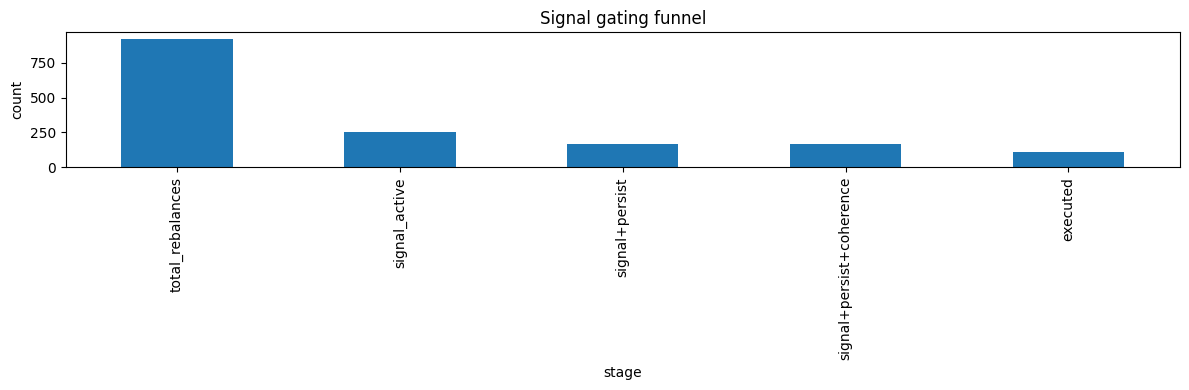

In [347]:
# Signal gating and activity funnel
if log_df is None or log_df.empty:
    print("No log data available for gating diagnostics.")
else:
    def _param_float_local(name, default):
        try:
            return float(algo_params.get(name, default))
        except Exception:
            return default

    def _param_int_local(name, default):
        try:
            return int(float(algo_params.get(name, default)))
        except Exception:
            return default

    sig_th = _param_float_local("signal_threshold", 2.0)
    sig_persist = _param_int_local("signal_persist", 2)

    df = log_df.copy()
    if "signal" in df:
        df["signal_active"] = df["signal"] >= sig_th
    else:
        df["signal_active"] = False
    if "persist" in df:
        df["persist_ok"] = df["persist"] >= sig_persist
    else:
        df["persist_ok"] = False
    if "state" in df:
        df["coherence_ok"] = df["state"] != "no_coherence"
        df["executed"] = df["state"] == "rebalance_ok"
    else:
        df["coherence_ok"] = True
        df["executed"] = False

    df["eligible"] = df["signal_active"] & df["persist_ok"] & df["coherence_ok"]

    total = len(df)
    signal_ok = int(df["signal_active"].sum())
    persist_ok = int((df["signal_active"] & df["persist_ok"]).sum())
    coherence_ok = int((df["signal_active"] & df["persist_ok"] & df["coherence_ok"]).sum())
    executed = int(df["executed"].sum())

    funnel = [
        ("total_rebalances", total),
        ("signal_active", signal_ok),
        ("signal+persist", persist_ok),
        ("signal+persist+coherence", coherence_ok),
        ("executed", executed),
    ]
    funnel_df = pd.DataFrame(funnel, columns=["stage", "count"])
    funnel_df["ratio"] = funnel_df["count"] / max(total, 1)
    display(funnel_df)

    ax = funnel_df.set_index("stage")["count"].plot(kind="bar", title="Signal gating funnel")
    ax.set_ylabel("count")
    plt.tight_layout()


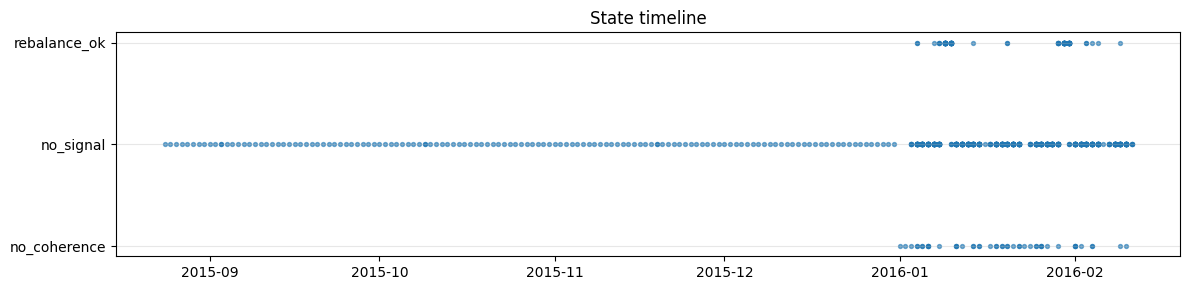

In [348]:
# State timeline and shutdown markers
if log_df is None or log_df.empty or "state" not in log_df.columns:
    print("No state timeline available.")
else:
    df = log_df.dropna(subset=["date"]).copy() if "date" in log_df.columns else log_df.copy()
    if "date" not in df.columns:
        print("No date column available for state timeline.")
    else:
        states = sorted(df["state"].dropna().unique())
        state_map = {state: i for i, state in enumerate(states)}
        df["state_code"] = df["state"].map(state_map)

        plt.figure(figsize=(12, 3))
        plt.scatter(df["date"], df["state_code"], s=8, alpha=0.6)
        plt.yticks(list(state_map.values()), list(state_map.keys()))
        plt.title("State timeline")
        plt.grid(True, axis="y", alpha=0.3)

        shutdowns = df[df["state"].str.startswith("shutdown", na=False)]
        if not shutdowns.empty:
            for t in shutdowns["date"]:
                plt.axvline(t, color="red", alpha=0.15)
        plt.tight_layout()


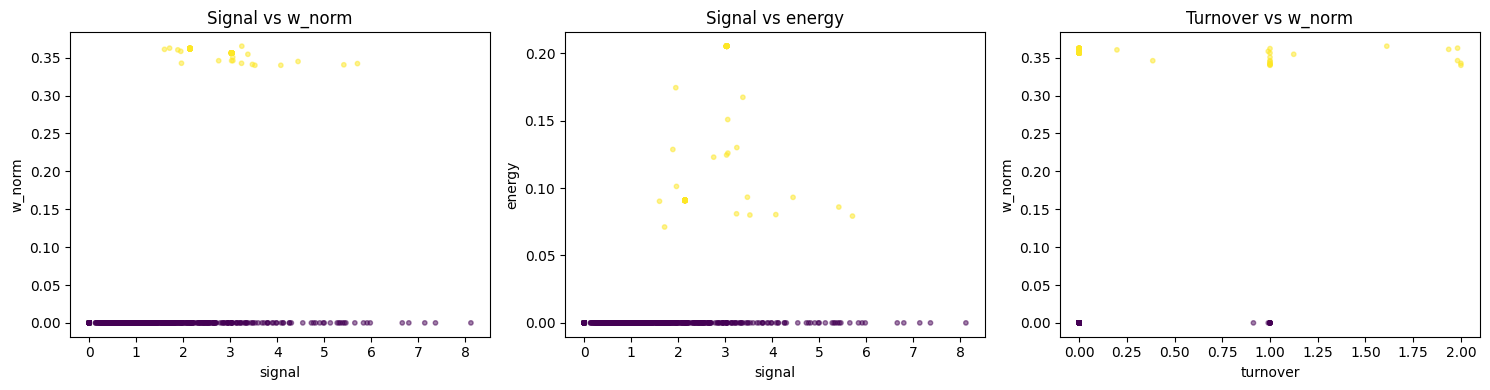

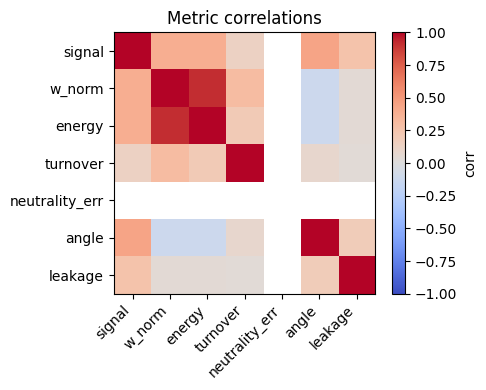

In [349]:
# Signal response vs risk relationships
if log_df is None or log_df.empty:
    print("No log data for relationship plots.")
else:
    df = log_df.copy()
    if "w_norm" in df.columns:
        df["active"] = df["w_norm"] > 0
    else:
        df["active"] = False

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    if {"signal", "w_norm"}.issubset(df.columns):
        axes[0].scatter(df["signal"], df["w_norm"], c=df["active"], s=10, alpha=0.5)
        axes[0].set_title("Signal vs w_norm")
        axes[0].set_xlabel("signal")
        axes[0].set_ylabel("w_norm")
    else:
        axes[0].set_visible(False)

    if {"signal", "energy"}.issubset(df.columns):
        axes[1].scatter(df["signal"], df["energy"], c=df["active"], s=10, alpha=0.5)
        axes[1].set_title("Signal vs energy")
        axes[1].set_xlabel("signal")
        axes[1].set_ylabel("energy")
    else:
        axes[1].set_visible(False)

    if {"turnover", "w_norm"}.issubset(df.columns):
        axes[2].scatter(df["turnover"], df["w_norm"], c=df["active"], s=10, alpha=0.5)
        axes[2].set_title("Turnover vs w_norm")
        axes[2].set_xlabel("turnover")
        axes[2].set_ylabel("w_norm")
    else:
        axes[2].set_visible(False)

    plt.tight_layout()

    corr_cols = [c for c in ["signal", "w_norm", "energy", "turnover", "neutrality_err", "angle", "leakage"] if c in df]
    if len(corr_cols) >= 2:
        corr = df[corr_cols].corr()
        plt.figure(figsize=(5, 4))
        plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
        plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
        plt.yticks(range(len(corr_cols)), corr_cols)
        plt.colorbar(label="corr")
        plt.title("Metric correlations")
        plt.tight_layout()


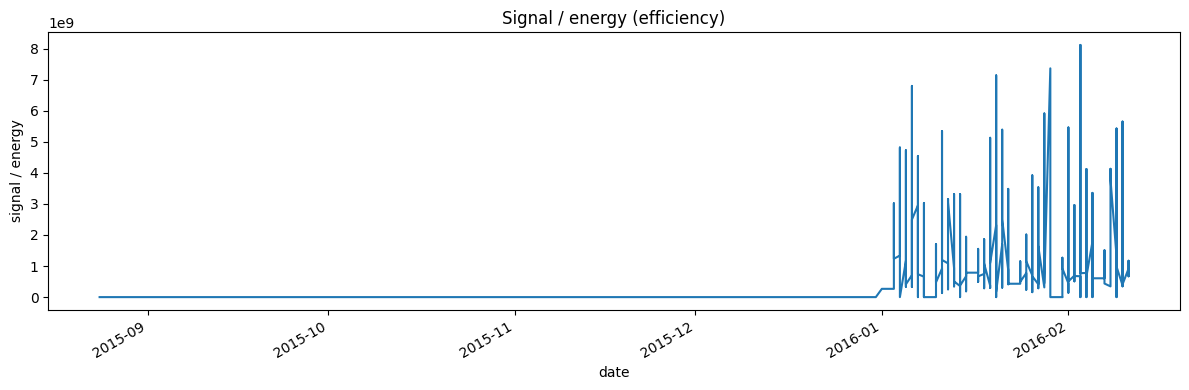

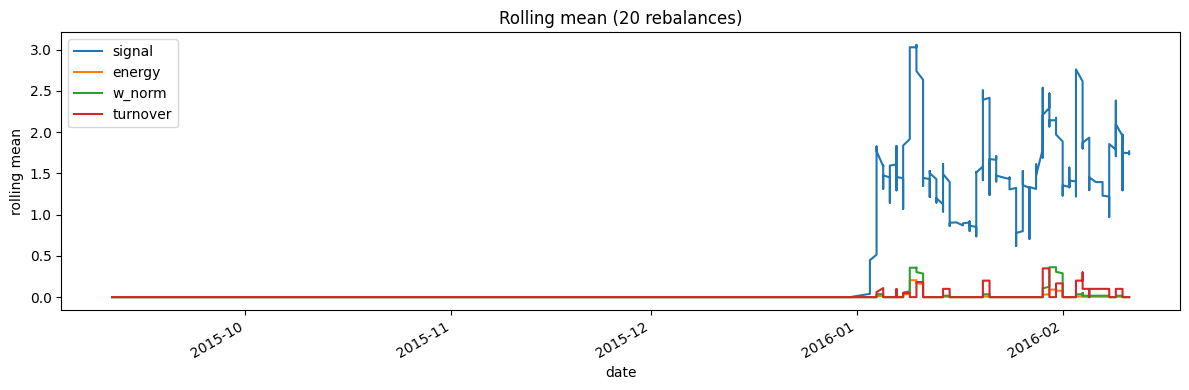

In [350]:
# Efficiency and rolling trends
if log_df is None or log_df.empty or "date" not in log_df.columns:
    print("No time series available for rolling diagnostics.")
else:
    df = log_df.dropna(subset=["date"]).copy()
    df = df.set_index("date").sort_index()
    if {"signal", "energy"}.issubset(df.columns):
        df["efficiency"] = df["signal"] / (df["energy"] + 1e-9)
        df["efficiency"].plot(title="Signal / energy (efficiency)")
        plt.ylabel("signal / energy")
        plt.tight_layout()

    roll = df[[c for c in ["signal", "energy", "w_norm", "turnover"] if c in df]].rolling(20).mean()
    if not roll.empty:
        ax = roll.plot(title="Rolling mean (20 rebalances)")
        ax.set_ylabel("rolling mean")
        plt.tight_layout()


In [351]:
# Shutdown precursors and diagnostic hints
if log_df is None or log_df.empty:
    print("No log data for shutdown diagnostics.")
else:
    df = log_df.copy()
    shutdown_mask = df.get("state", "").str.startswith("shutdown", na=False) if "state" in df else False
    shutdown_idx = df.index[shutdown_mask] if hasattr(shutdown_mask, "__iter__") else []

    if len(shutdown_idx) > 0:
        rows = []
        for idx in shutdown_idx:
            start = max(0, idx - 5)
            window = df.iloc[start : idx + 1]
            row = {
                "shutdown_index": int(idx),
                "state": df.loc[idx, "state"] if "state" in df else None,
                "mean_signal": float(window["signal"].mean()) if "signal" in window else None,
                "mean_energy": float(window["energy"].mean()) if "energy" in window else None,
                "mean_w_norm": float(window["w_norm"].mean()) if "w_norm" in window else None,
                "max_neutrality": float(window["neutrality_err"].max()) if "neutrality_err" in window else None,
            }
            rows.append(row)
        display(pd.DataFrame(rows))
    else:
        print("No shutdown events detected.")

    # Heuristic hints
    hints = []
    active_ratio = float((df.get("w_norm", 0) > 0).mean()) if "w_norm" in df else 0.0
    no_coh_ratio = float((df.get("state", "") == "no_coherence").mean()) if "state" in df else 0.0
    shutdown_ratio = float(shutdown_mask.mean()) if hasattr(shutdown_mask, "mean") else 0.0

    if active_ratio < 0.1:
        hints.append("System is mostly idle; signal/persistence/coherence gates may be too strict or residuals weak.")
    if no_coh_ratio > 0.3:
        hints.append("Coherence filter rejects many signals; check participation_eps/min_participation_frac or residual structure.")
    if shutdown_ratio > 0.02:
        hints.append("Shutdowns are frequent; energy or subspace stability may be too fragile for the universe.")

    if "neutrality_err" in df:
        near_fail = (df["neutrality_err"] > NEUTRALITY_FAIL_TOL * 0.5).mean()
        if near_fail > 0.2:
            hints.append("Neutrality error often near tolerance; clipping/rescaling may be breaking constraints.")

    if "angle" in df:
        high_angle = (df["angle"] > SUBSPACE_BREAK_TOL * 0.7).mean()
        if high_angle > 0.2:
            hints.append("Subspace angle often elevated; PCA space may be unstable for this universe.")

    if "leakage" in df:
        high_leak = (df["leakage"] > 0.8).mean()
        if high_leak > 0.3:
            hints.append("Factor leakage is high; most movement sits in factor space, leaving weak residual signal.")

    if "energy" in df:
        high_energy = (df["energy"] > MAX_ENERGY * 0.7).mean()
        if high_energy > 0.2:
            hints.append("Energy frequently near the guard; regularization may be too weak or signal too noisy.")

    if health_df is not None and "alignment" in health_df:
        median_align = float(health_df["alignment"].median())
        if abs(median_align) < 0.1:
            hints.append("Alignment is near zero on average; the signal may not transmit to weights.")

    print("Diagnostic hints:")
    if hints:
        for hint in hints:
            print("-", hint)
    else:
        print("- No strong red flags detected by heuristics.")


No shutdown events detected.
Diagnostic hints:
- Factor leakage is high; most movement sits in factor space, leaving weak residual signal.
- Alignment is near zero on average; the signal may not transmit to weights.


## Beta Window Sensitivity (Lookback Scan)

This section scans recent backtests and groups results by `lookback_returns`
to highlight stability vs window length using structural metrics only.


,lookback_returns,mean_subspace_angle,mean_factor_leakage,mean_signal_strength,mean_energy,mean_w_norm,mean_turnover,mean_neutrality_err,active_ratio,mean_efficiency
0,168,NaN,NaN,1.512373,0.073142,0.074363,0.084016,1.256942e-17,0.215231,9.435507e+08
1,252,NaN,NaN,1.021389,0.405495,0.095025,0.380223,1.484523e-17,0.129934,7.391663e+08
2,720,NaN,NaN,1.115618,0.032524,0.048572,0.195679,9.646761e-18,0.093688,9.367456e+08
3,1440,NaN,NaN,0.937109,0.002076,0.014014,0.044611,2.242560e-18,0.034745,8.644376e+08


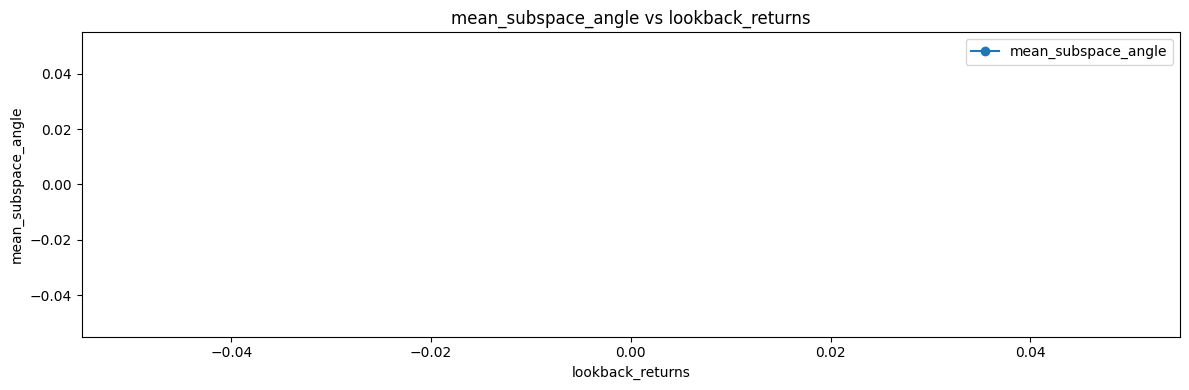

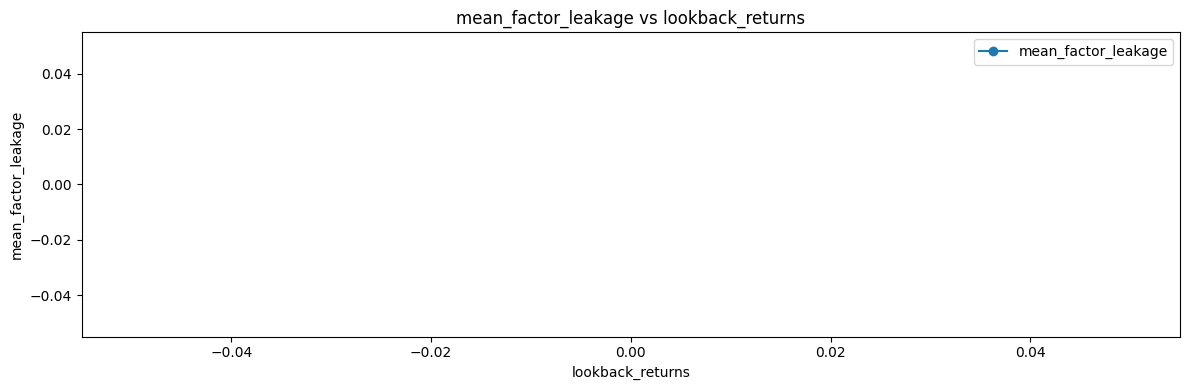

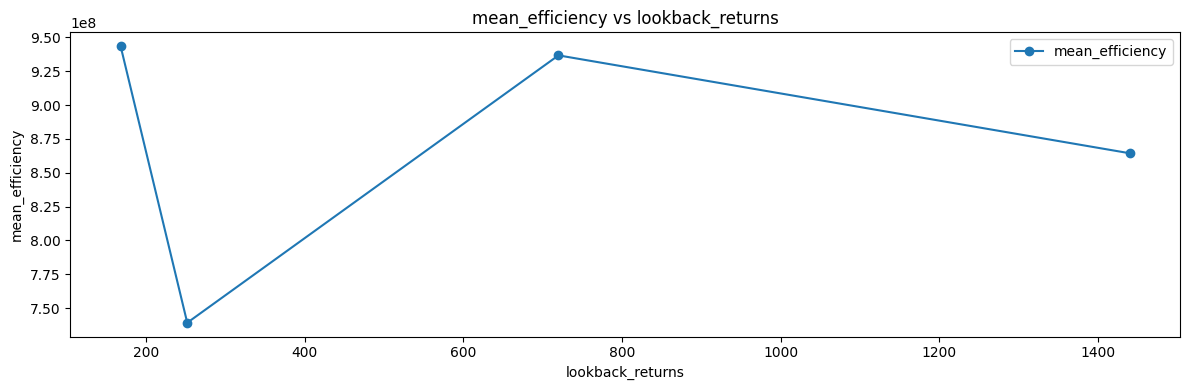

In [352]:
from pathlib import Path
import json

SCAN_ROOTS = [
    Path.home() / "lean-cli-root" / "ResidualStateEngine" / "backtests",
]
SCAN_LIMIT = 40  # number of most recent backtests to scan

FILTERS = {
    "asset_type": None,
    "resolution": None,
    "strategy_variant": None,
    "dataset_profile": None,
}

def _latest_backtests(roots, limit=40):
    candidates = []
    for root in roots:
        if not root.exists():
            continue
        for child in root.iterdir():
            if child.is_dir():
                candidates.append(child)
    candidates.sort(key=lambda d: d.stat().st_mtime, reverse=True)
    return candidates[:limit]

def _pick_json(backtest_dir):
    json_files = []
    for path in backtest_dir.glob('*.json'):
        if path.name.endswith('-summary.json') or path.name.endswith('-order-events.json'):
            continue
        json_files.append(path)
    if not json_files:
        return None
    # Prefer a JSON with Health chart
    for path in json_files:
        try:
            data = json.loads(path.read_text())
        except Exception:
            continue
        if isinstance(data, dict) and data.get('charts', {}).get('Health'):
            return path
    return json_files[0]

def _read_health_series(bt_data):
    charts = bt_data.get('charts', {})
    health_chart = charts.get('Health', {})
    series = health_chart.get('series', {})
    out = {}
    for name, payload in series.items():
        values = payload.get('values', [])
        out[name] = [float(v[-1]) for v in values if v]
    return out

def _summarize_metrics(series):
    summary = {}
    for name, values in series.items():
        if not values:
            continue
        mean_val = sum(values) / len(values)
        summary[f"mean_{name}"] = float(mean_val)
        summary[f"max_{name}"] = float(max(values))

    if 'w_norm' in series and series['w_norm']:
        active = sum(1 for v in series['w_norm'] if v > 0)
        summary['active_ratio'] = active / len(series['w_norm'])

    if 'signal_strength' in series and 'energy' in series:
        s_vals = series['signal_strength']
        e_vals = series['energy']
        n = min(len(s_vals), len(e_vals))
        if n > 0:
            eff = [s_vals[i] / (e_vals[i] + 1e-9) for i in range(n)]
            summary['mean_efficiency'] = float(sum(eff) / n)

    return summary

def _match_filters(params, filters):
    for key, expected in filters.items():
        if expected is None:
            continue
        actual = params.get(key)
        if actual is None:
            return False
        if str(actual).lower() != str(expected).lower():
            return False
    return True

rows = []
for bt_dir in _latest_backtests(SCAN_ROOTS, SCAN_LIMIT):
    json_path = _pick_json(bt_dir)
    if json_path is None:
        continue
    try:
        data = json.loads(json_path.read_text())
    except Exception:
        continue
    if not isinstance(data, dict):
        continue
    params = data.get('algorithmConfiguration', {}).get('parameters', {}) or {}
    if not _match_filters(params, FILTERS):
        continue
    series = _read_health_series(data)
    if not series:
        continue
    summary = _summarize_metrics(series)
    row = {
        'backtest_dir': str(bt_dir),
        'lookback_returns': params.get('lookback_returns'),
        'resolution': params.get('resolution'),
        'asset_type': params.get('asset_type'),
        'strategy_variant': params.get('strategy_variant'),
        'dataset_profile': params.get('dataset_profile'),
    }
    row.update(summary)
    rows.append(row)

scan_df = pd.DataFrame(rows)
if scan_df.empty:
    print('No backtests matched filters for lookback scan.')
else:
    scan_df['lookback_returns'] = pd.to_numeric(scan_df['lookback_returns'], errors='coerce')
    scan_df = scan_df.dropna(subset=['lookback_returns'])
    scan_df['lookback_returns'] = scan_df['lookback_returns'].astype(int)

    metric_cols = [c for c in [
        'mean_subspace_angle',
        'mean_factor_leakage',
        'mean_signal_strength',
        'mean_energy',
        'mean_w_norm',
        'mean_turnover',
        'mean_neutrality_err',
        'active_ratio',
        'mean_efficiency',
    ] if c in scan_df.columns]

    grouped = scan_df.groupby('lookback_returns')[metric_cols].mean().reset_index()
    display(grouped.sort_values('lookback_returns'))

    # Plot key stability metrics vs lookback
    for col in ['mean_subspace_angle', 'mean_factor_leakage', 'mean_efficiency']:
        if col in grouped:
            ax = grouped.plot(x='lookback_returns', y=col, marker='o', title=f'{col} vs lookback_returns')
            ax.set_xlabel('lookback_returns')
            ax.set_ylabel(col)
            plt.tight_layout()


## Notes

- This notebook is designed to be rerun after new backtests.
- It focuses on internal metrics and lifecycle behavior, not PnL.
- If Health chart data is missing, rely on the log-derived metrics.

## Compare Last Two Backtests

In [353]:
from pathlib import Path
import json


def _latest_backtests(roots, count=2):
    candidates = []
    for root in roots:
        if not root.exists():
            continue
        for child in root.iterdir():
            if child.is_dir():
                candidates.append(child)
    candidates.sort(key=lambda d: d.stat().st_mtime, reverse=True)
    return candidates[:count]


def _pick_json(backtest_dir):
    json_files = []
    for path in backtest_dir.glob('*.json'):
        if path.name.endswith('-summary.json') or path.name.endswith('-order-events.json'):
            continue
        json_files.append(path)
    return json_files[0] if json_files else None


def _read_stats(json_path):
    if json_path is None or not json_path.exists():
        return {}
    with json_path.open() as f:
        data = json.load(f)
    return data.get('statistics', {})


roots = [
    Path.cwd() / 'backtests',
    Path.home() / 'lean-cli-root' / 'ResidualStateEngine' / 'backtests',
]

latest = _latest_backtests(roots, count=2)
rows = []
for bt in latest:
    json_path = _pick_json(bt)
    stats = _read_stats(json_path)
    row = {
        'backtest_dir': str(bt),
        'json': json_path.name if json_path else None,
        'Net Profit': stats.get('Net Profit'),
        'Total Fees': stats.get('Total Fees'),
        'Portfolio Turnover': stats.get('Portfolio Turnover'),
        'Drawdown': stats.get('Drawdown'),
        'End Equity': stats.get('End Equity'),
    }
    rows.append(row)

pd.DataFrame(rows)

,backtest_dir,json,Net Profit,Total Fees,Portfolio Turnover,Drawdown,End Equity
0,/Users/javiergonzalez-quijanoalvarez/lean-cli-...,1725405904.json,None,None,None,None,None
1,/Users/javiergonzalez-quijanoalvarez/lean-cli-...,1755419414.json,None,None,None,None,None


In [354]:
from pathlib import Path
import json


def _latest_backtests(roots, count=2):
    candidates = []
    for root in roots:
        if not root.exists():
            continue
        for child in root.iterdir():
            if child.is_dir():
                candidates.append(child)
    candidates.sort(key=lambda d: d.stat().st_mtime, reverse=True)
    return candidates[:count]


def _pick_json(backtest_dir):
    json_files = []
    for path in backtest_dir.glob('*.json'):
        if path.name.endswith('-summary.json') or path.name.endswith('-order-events.json'):
            continue
        json_files.append(path)

    # Prefer JSONs that have statistics
    for path in json_files:
        try:
            data = json.loads(path.read_text())
        except Exception:
            continue
        if isinstance(data, dict) and data.get('statistics'):
            return path

    return json_files[0] if json_files else None


def _read_stats(json_path):
    if json_path is None or not json_path.exists():
        return {}
    with json_path.open() as f:
        data = json.load(f)
    return data.get('statistics', {}) if isinstance(data, dict) else {}


roots = [
    Path.cwd() / 'backtests',
    Path.home() / 'lean-cli-root' / 'ResidualStateEngine' / 'backtests',
]

latest = _latest_backtests(roots, count=2)
rows = []
for bt in latest:
    json_path = _pick_json(bt)
    stats = _read_stats(json_path)
    row = {
        'backtest_dir': str(bt),
        'json': json_path.name if json_path else None,
        'Net Profit': stats.get('Net Profit'),
        'Total Fees': stats.get('Total Fees'),
        'Portfolio Turnover': stats.get('Portfolio Turnover'),
        'Drawdown': stats.get('Drawdown'),
        'End Equity': stats.get('End Equity'),
    }
    rows.append(row)

pd.DataFrame(rows)

,backtest_dir,json,Net Profit,Total Fees,Portfolio Turnover,Drawdown,End Equity
0,/Users/javiergonzalez-quijanoalvarez/lean-cli-...,1725405904.json,None,None,None,None,None
1,/Users/javiergonzalez-quijanoalvarez/lean-cli-...,1755419414.json,None,None,None,None,None
